# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Elisabetta Pagliara and Liangwei Chen  
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

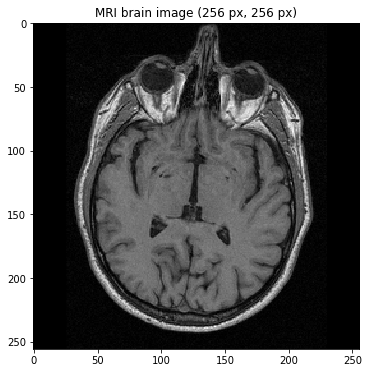

In [8]:
import skimage.io
import numpy as np

from skimage.filters import sobel
from skimage import measure
import cv2
import scipy

from sklearn.mixture import GaussianMixture

import scipy.stats 
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from skimage import feature

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
plt.show()

### 1.2 Region growing



Let's start looking at a simple histogram representation:

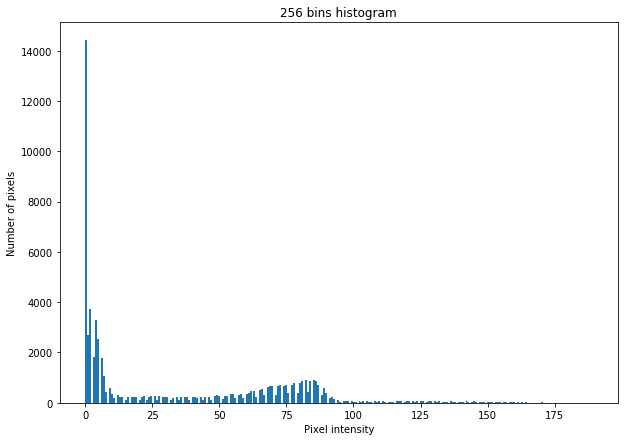

In [4]:
plt.figure(figsize=(10,7))
plt.hist(brain_im.ravel(), bins=256)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')
plt.show()

From the histogram it's possible to identify two clusters of pixels.
In this exercise, we are asked to compute the brain size, so to understand which cluster we should use in our analysis, we print the value of a pixel that belongs to a brain region.

In [19]:
brain_im[150,150]

79

The value just found suggests to consider the small cluster, but it's important to relise that the second cluster includes also other brain regios not useful in this analysis (ex: eyes). Because of this, we agree that a good balance is given by using a double thresold.

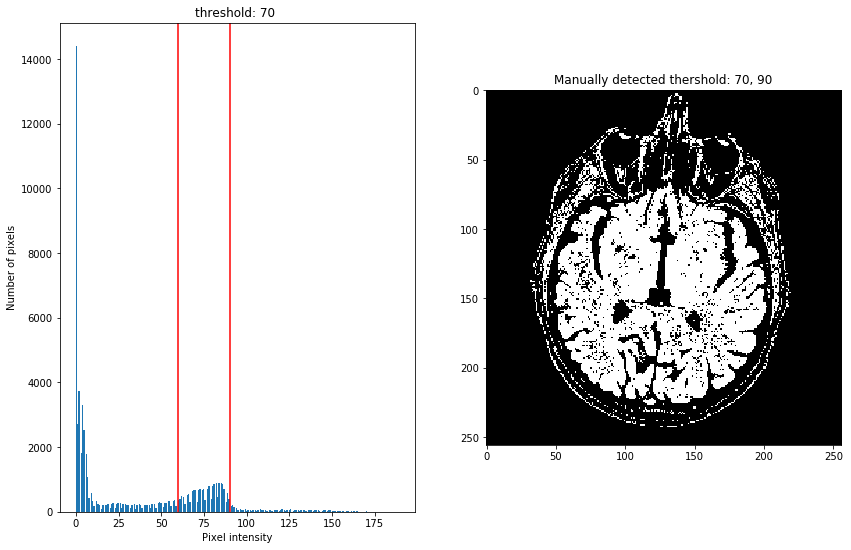

In [46]:
brain_im_threhsold=np.where((brain_im>60) & (brain_im<90),256,0)


plt.figure(figsize=(14,9))
plt.subplot(1,2,1)
plt.hist(brain_im.ravel(), bins=256)
plt.axvline(60, color='r')
plt.axvline(90, color='r')
plt.title('threshold: {} '.format(thresh))
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')


plt.subplot(1,2,2)
plt.imshow(brain_im_threhsold,cmap='gray')
plt.title('Manually detected thershold: {}, {}'.format(70,90))
plt.show()

The first algorithm is region growing:
Let's start from a random seed: [150,150] that belongs to the foreground


Initial seed point: [150, 150]


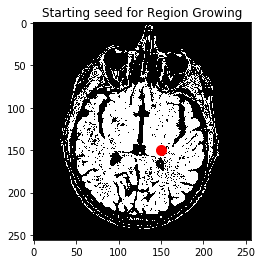

In [47]:
pseed = [150,150] 
print ('\nInitial seed point: {}'.format(pseed))
plt.imshow(brain_im_threhsold,cmap='gray')
plt.scatter(x=pseed[0],y=pseed[1],c='r',s=100)
plt.title('Starting seed for Region Growing')
plt.show()

The region growing method is implemented in this way:
- we start considering a seed belonging to the foreground
- the function: 'get_position' looks at the 8 nearest neighboorhood of the seed, taking the ones that belong to the foreground and assigning a True value at each pixel seen by the algorithm, in order to avoid to see the same pixel twice
- each of the pixel in the function 'get_position' is then evaluated by the function 'neighboorhood' to verify if all its 8 nearest neighboorhood are part of the foreground
- if it's the case, the pixel of 'get_position' function is included into the region growing and on this pixel, we apply the function 'get_position' to gather more regions to explore, otherise we keep going with the pixels already store in get_position
- the algorithm stops when the function 'get_position' is empty.

In [48]:
def neighboorhood(pseed,image):
    #8 connectivity
    
    t=1
    if (image[pseed[0],pseed[1]]>=np.mean(image[pseed[0]-t*1:pseed[0]+t*1,pseed[1]-t*1:pseed[1]+t*1])):
           return True 
    else:
          return False
        


In [49]:
def get_position(pseed,binary,image_growing_contour):
    #8 connectivity
    vector_position=[]
    if (binary[pseed[0]+1,pseed[1]]==256) & (image_growing_contour[pseed[0]+1,pseed[1]]!=True ):
        vector_position.append((pseed[0]+1,pseed[1]))
        
    if(binary[pseed[0]-1,pseed[1]]==256) & (image_growing_contour[pseed[0]-1,pseed[1]]!=True ):
        vector_position.append((pseed[0]-1,pseed[1]))
        
    if(binary[pseed[0],pseed[1]+1]==256) & (image_growing_contour[pseed[0],pseed[1]+1]!=True ):
        vector_position.append((pseed[0],pseed[1]+1))
        
    if(binary[pseed[0],pseed[1]-1]==256) & (image_growing_contour[pseed[0],pseed[1]-1]!=True ):
        vector_position.append((pseed[0],pseed[1]-1))
        
    if(binary[pseed[0]+1,pseed[1]+1]==256) & (image_growing_contour[pseed[0]+1,pseed[1]+1]!=True ):
        vector_position.append((pseed[0]+1,pseed[1]+1))
        
    if(binary[pseed[0]-1,pseed[1]-1]==256) & (image_growing_contour[pseed[0]-1,pseed[1]-1]!=True ):
        vector_position.append((pseed[0]-1,pseed[1]-1))
        
    if(binary[pseed[0]+1,pseed[1]-1]==256) & (image_growing_contour[pseed[0]+1,pseed[1]-1]!=True ):
        vector_position.append((pseed[0]+1,pseed[1]-1))
        
    if(binary[pseed[0]-1,pseed[1]+1]==256) & (image_growing_contour[pseed[0]-1,pseed[1]+1]!=True ):
        vector_position.append((pseed[0]-1,pseed[1]+1))
        
    return vector_position
    


In [50]:
def remove_duplicates(duplicate):
    
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list
    

In [51]:
image_growing_contour=np.zeros((binary.shape[0],binary.shape[1]))
  
x,y=pseed[0],pseed[1]
image_growing_contour[x,y]=True if neighboorhood(pseed,binary) else print('Choose a new point in the foreground !')
motion_vector=get_position(pseed,binary,image_growing_contour)
motion_vector_update=[]

k=0
#motion in all the positions
while(len(motion_vector)-1>0):
    k+=1
    print('iteration :{}'.format(k))
    for i in range(len(motion_vector)-1):
        if neighboorhood(motion_vector[i],binary):
            image_growing_contour[motion_vector[i][0],motion_vector[i][1]]=True   
            increase_position=get_position(motion_vector[i],binary,image_growing_contour)
            motion_vector_update=motion_vector_update+((increase_position))
            
            
    motion_vector=remove_duplicates(motion_vector_update)
    motion_vector_update=[]
        
      

iteration :1
iteration :2
iteration :3
iteration :4
iteration :5
iteration :6
iteration :7
iteration :8
iteration :9
iteration :10
iteration :11
iteration :12
iteration :13
iteration :14
iteration :15
iteration :16
iteration :17
iteration :18
iteration :19
iteration :20
iteration :21
iteration :22
iteration :23
iteration :24
iteration :25
iteration :26
iteration :27
iteration :28
iteration :29
iteration :30
iteration :31
iteration :32
iteration :33
iteration :34
iteration :35
iteration :36
iteration :37
iteration :38
iteration :39
iteration :40
iteration :41
iteration :42
iteration :43
iteration :44
iteration :45
iteration :46
iteration :47
iteration :48
iteration :49
iteration :50
iteration :51
iteration :52
iteration :53
iteration :54
iteration :55
iteration :56
iteration :57
iteration :58
iteration :59
iteration :60
iteration :61
iteration :62
iteration :63
iteration :64
iteration :65
iteration :66
iteration :67
iteration :68
iteration :69
iteration :70
iteration :71
iteration :72
i

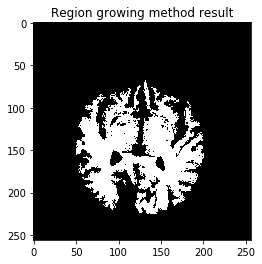

In [52]:
plt.imshow(image_growing_contour,cmap='gray')
plt.title('Region growing method result')
plt.show()

In [53]:
print('size of the brain :{} by region growing method'.format(np.sum(image_growing_contour)))

size of the brain :11528.0 by region growing method


The result appears quite good, of course some pixels are not taken into consideration in this algorithm, lowering the size of the brain.

### 1.3 Contour detection: Canny


In [54]:
brain_out = brain_im.copy()
brain_out[brain_im_threhsold==0] = (0)

edges = feature.canny(brain_out, sigma=3.2)
dilation_brain=scipy.ndimage.binary_dilation(edges, structure=np.ones((8,8))).astype('uint8')
dilation_brain=scipy.ndimage.binary_erosion(dilation_brain, structure=np.ones((6,6))).astype('uint8')


brain_out2 = brain_im.copy()
brain_out2[dilation_brain==0]=0


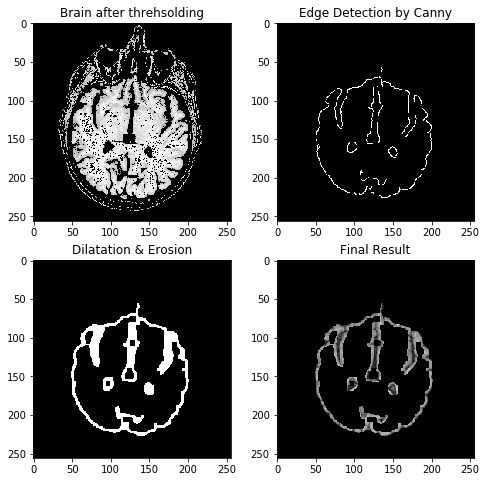

In [55]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(brain_out,cmap='gray')
plt.title('Brain after threhsolding')

plt.subplot(2,2,2)
plt.imshow(edges,cmap='gray')
plt.title('Edge Detection by Canny')

plt.subplot(2,2,3)
plt.imshow(dilation_brain,cmap='gray')
plt.title('Dilatation & Erosion')


plt.subplot(2,2,4)
plt.imshow(brain_out2,cmap='gray')
plt.title('Final Result')
plt.show()


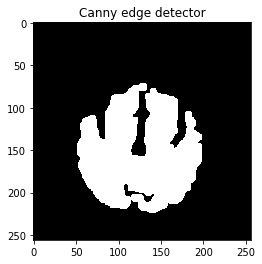

In [56]:
zeros=np.zeros((brain_im.shape[0],brain_im.shape[1]))
filtered_contour, contours,_ = cv2.findContours(dilation_brain.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plt.title('Canny edge detector')
plt.imshow(cv2.drawContours(zeros, contours, 4, (255, 255, 255), -1),cmap='gray')
plt.show()

In [58]:
print('brain contours with Canny method: {}'.format(np.sum(zeros!=0)))

brain contours with Canny method: 14810


In this exercise we use a Canny detector with sigma value quite high to remove edges that we were not interested in.
The successful result of the algorithm is given by the input image that the Canny detector receives.
In fact, we pay particolar attention choosing a good range of values for the gray matter, avoiding the problem with dealing with the white matter.

In order to identify close edges after applying Canny detector, a dilation and erosion operation ( with different kernel size) are used.

# 1.3 Sobel

In [59]:
edges = sobel(brain_out)
erosion_brain=scipy.ndimage.binary_erosion(edges, structure=np.ones((8,6))).astype('uint8')
brain_out2 = brain_im.copy()
brain_out2[erosion_brain==0]=0

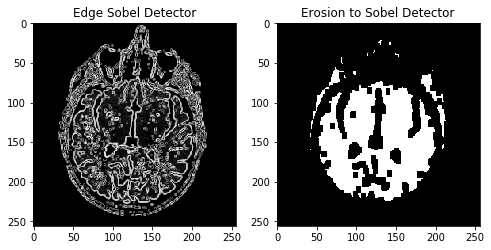

In [60]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(edges,cmap='gray')
plt.title('Edge Sobel Detector')
plt.subplot(1,2,2)
plt.imshow(erosion_brain,cmap='gray')
plt.title('Erosion to Sobel Detector')
plt.show()

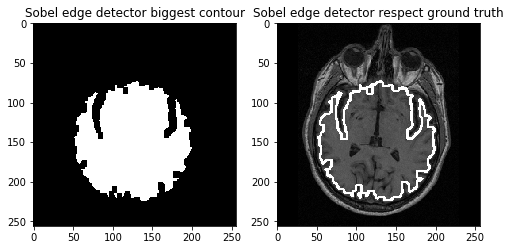

In [61]:
area=[]
filtered_contour, contours,_ = cv2.findContours(erosion_brain, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
        
        area.append((cv2.contourArea(contour)))
max_cont=np.argsort(area)[-1]   

zeros=np.zeros((brain_im.shape[0],brain_im.shape[1]))
brain_im2=brain_im.copy()

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.title('Sobel edge detector biggest contour')
plt.imshow(cv2.drawContours(zeros, contours, max_cont, (255, 25, 25), -1),cmap='gray')

plt.subplot(1,2,2)
plt.title('Sobel edge detector respect ground truth')
plt.imshow(cv2.drawContours(brain_im2, contours, max_cont, (255, 25, 25), 2),cmap='gray')

plt.show()


In [65]:
print('brain size with Sobel detector: {}'.format(np.sum(zeros/255)))

brain size with Sobel detector: 15307.0


Another edge detection is now used: the Sobel detector.
The input image is the same as for the Canny detector, but in this case the Sobel operator retains a lot of non-useful details. For this reason the erosion morphological operation is applied.
After that, we extract the biggest contour that represents the brain size.

A first comparison among the two edge detection methods used should be done:

The qualitiy of the recostruction of the brain with Sobel operator is worst respect than Canny. In fact, we can not distinguish the ventriculi and other solcus in the brain like in Canny.

This is due to the fact that in Sobel, we adopt for the method:' Find Contour', where actually we look for the biggest contour that it's the brain size, not taking in consideration the others. 
In this context, we are forced to use this method we couldn't increase the size of the erosion mask to not lose useful data, and dilation operator is not even an option.

The superiority of the Canny detector is garanteed by the Gaussian Blurring that it's applied when we acquired the image and by the Non-Max Suppression, Double Threhsolding and the Hysteris procedure where we can mitigate among thick and less thicker edges.

# Laplace of Gaussian

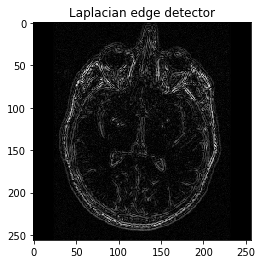

In [349]:
# Play with Laplacian of Gaussian

# Build smoothed img
smooth_img = cv2.GaussianBlur(brain_im, (3, 3), 0)

# Calculate Laplacian of Gaussian
abs_dst = cv2.convertScaleAbs(cv2.Laplacian(smooth_img, cv2.CV_16S, 3))

# Visualize edge detected
plt.imshow(abs_dst, cmap = 'gray')
plt.title('Laplacian edge detector')
plt.show()

In [350]:
# Convert img to binary by filtering with selected threshold
filtered_img = brain_im > 70

# Convert to unsigned 8 bit int type
filtered_img.astype(np.uint8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [351]:
# Conduct morphology open operation with 4 * 4 kernel
filtered_img = cv2.morphologyEx(filtered_img.astype(np.uint8), cv2.MORPH_OPEN,
               np.ones((4, 4), np.uint8))

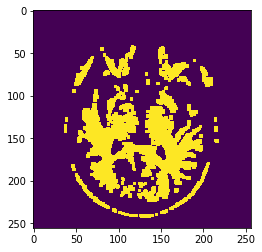

In [352]:
plt.imshow(filtered_img)

In [353]:
# Find contour of morphology operation result
_,filtered_contour, _ = cv2.findContours(filtered_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [354]:
# Convert filtered img to 3d for visualization
filtered_img = cv2.cvtColor(filtered_img, cv2.COLOR_GRAY2RGB)

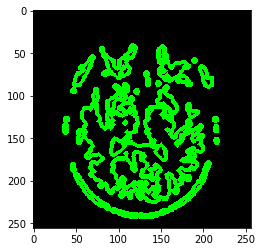

In [355]:
# Show the contour of morphology result
plt.imshow( cv2.drawContours(filtered_img, filtered_contour, -1, (0, 255, 0), 3),cmap='gray')

Notice that the longest contour should be regarded as the target contour for brain.

In [356]:
# Get the longest contour
longest_contour = sorted(filtered_contour, key = len)[-1]

In [357]:
print('length of longest contour is {0}'.format(len(longest_contour)))

length of longest contour is 753


In the following section we try to use convex hull and polygon to approximate the irregular contour

In [358]:
# Draw convex hull

# Initialize
drawing = np.zeros((256, 256, 3))
color_contours = (0, 255, 0)
color_hull = (255, 0, 0)

# Draw
cv2.drawContours(drawing, [longest_contour], -1, color_contours, 3)
cv2.drawContours(drawing, [hull], -1, color_hull, 3)
plt.imshow(drawing,cmap='gray')


NameError: name 'hull' is not defined

In [ ]:
# Find approximation polygon

# Initialize
polygon_figure = np.zeros((256, 256, 3))
epi_coef = 0.005
epi = cv2.arcLength(filtered_contour[11], True) * epi_coef
# Draw approximation polygon
approx = cv2.approxPolyDP(filtered_contour[11], epi, True)
cv2.drawContours(polygon_figure, [filtered_contour[11]], -1, color_hull, 2)
cv2.drawContours(polygon_figure, [approx], -1, color_contours, 2)
plt.imshow(polygon_figure)


In [ ]:
# Get number of point inside or on the contour

# Initialize content matrix
content_matrix = np.zeros((256, 256))

# Set point value to 1 if point resides in contour
for i in np.arange(content_matrix.shape[0]):
    
    for j in np.arange(content_matrix.shape[1]):
        
        content_matrix[j][i] = cv2.pointPolygonTest(filtered_contour[11], (i, j), False) >= 0

In [ ]:
# Display the selected points and original results
plt.subplot(121).imshow(content_matrix * 128, cmap = 'gray')
plt.subplot(122).imshow(brain_im, cmap = 'gray')

In [ ]:

print('Size of brain area is ' + str(int(np.sum(content_matrix))) + ' pixels using' + \
        ' contour detection')

### 1.4 Thresholding


Let's start looking again at a simple histogram representation:

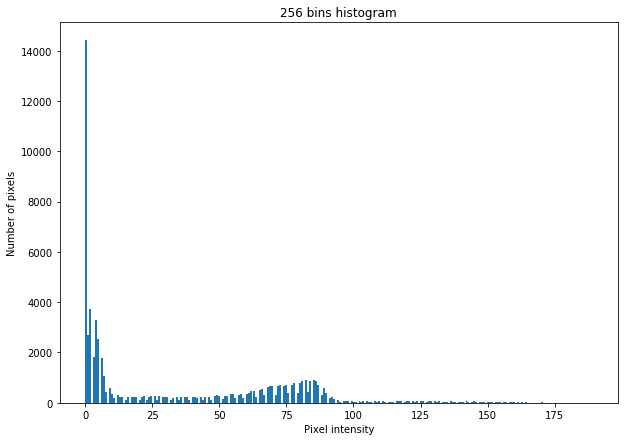

In [67]:
plt.figure(figsize=(10,7))
plt.hist(brain_im.ravel(), bins=256)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')
plt.show()

Looking at the bimodal histogram, we could approximate the shape of the two peaks as two gaussian distributions. What could we do to find the optimal threshold?
1. If one knows regions that are obviously in the background, we can easily estimate its distribution
2. We can define a model (e.g. Gaussian) and fit curves to the histogram


In [68]:
data=np.concatenate((brain_im.ravel().reshape(-1,1)))

In [69]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 2, tol=0.000001,max_iter=200)
gmm.fit(np.expand_dims(data, 1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=1e-06, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

Gaussian 1: μ = 6.6e+01, σ = 3.1e+01, weight = 0.52
Gaussian 2: μ = 2.0, σ = 2.4, weight = 0.48


/Users/elisabetta/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


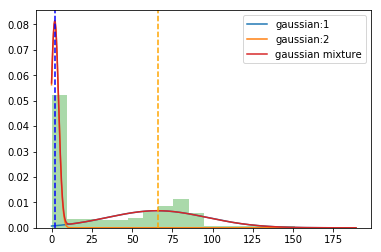

In [70]:
import scipy.stats 
import seaborn as sns
x = np.linspace(np.min(data), np.max(data), 2000) 
Gaussian_nr = 1
for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
    print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format(Gaussian_nr, mu, sd, p))
    g_s = scipy.stats.norm(mu, sd).pdf(x) * p
    plt.plot(x, g_s, label='gaussian:{}'.format(Gaussian_nr));
    Gaussian_nr += 1
sns.distplot(data, bins=20, kde=False, norm_hist=True)
gmm_sum = np.exp([gmm.score_samples(e.reshape(-1, 1)) for e in x]) #gmm gives log probability, hence the exp() function
plt.plot(x, gmm_sum, label='gaussian mixture')
plt.axvline(2, color="b", linestyle="--");
plt.axvline(66, color="orange", linestyle="--");
plt.legend()

the optimal threshold is the average of the two mean !!

In [72]:
threshold=round(np.mean(gmm.means_.flatten()))
threshold

34.0

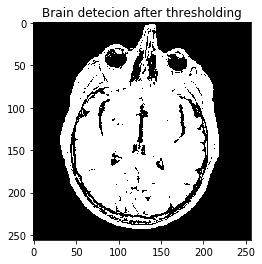

In [75]:
brain_im_Gaussian=np.where(brain_im>threshold,256,0)
plt.imshow(brain_im_Gaussian,cmap='gray')
plt.title('Brain detecion after thresholding')
plt.show()

thi threhsold allows for an optimal division among foreground/backgrouns, but it's really hard to define the brain size.
For this reason, we recall thedouble thresholding that we defined before.

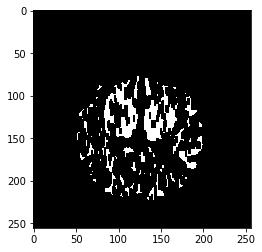

In [76]:
import scipy
erosion_brain=scipy.ndimage.binary_erosion(brain_im_threhsold, structure=np.ones((8,3))).astype(brain_im_threhsold.dtype)
plt.imshow(erosion_brain,cmap='gray')

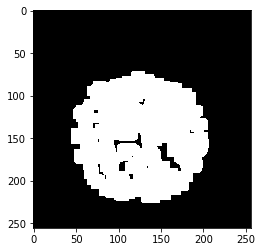

In [78]:
dilation_brain=scipy.ndimage.binary_dilation(erosion_brain, structure=np.ones((10,15))).astype(brain_im_threhsold.dtype)
plt.imshow(dilation_brain,cmap='gray')
plt.show()

In [79]:
print('size of the brain by thresholding method is : {}'.format(np.sum(dilation_brain)))

size of the brain by thresholding method is : 18909


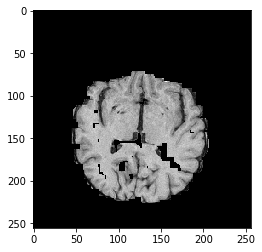

In [81]:
brain_im2=brain_im.copy()
brain_im2[dilation_brain==0] = (0)
plt.imshow(brain_im2,cmap='gray')
plt.show()

Thresholding method allows a quite good good representation that needs the attention of the operator in order to find the correct threshold.

# 1.5 Splitting and merge:


In [117]:
def uniform_criteria(index,threshold,image):
    image=image[index[0]:index[1],index[2]:index[3]]
    if np.std(image.ravel())>threshold:
        return True   
    else :
        return False

In [111]:
def splitting_image_later(index):
    x=int((np.abs(index[1]-index[0])/2))
    y=int((np.abs(index[3]-index[2])/2))
    
    matrix1=(index[0],index[0]+x,index[2],index[2]+y)
    matrix2=(index[0],index[0]+x,index[2]+y,index[3])
    matrix3=(index[0]+x,index[1],index[2],index[2]+y)
    matrix4=(index[0]+x,index[1],index[2]+y,index[3])
    
    return matrix1, matrix2, matrix3, matrix4

In [251]:
import cv2
brain_blurred=cv2.GaussianBlur(brain_im, (5,5), 0, 0);
brain=np.zeros((np.shape(brain_blurred)[0],np.shape(brain_blurred)[1]))

#splitting method
result2=[]
k=1
threshold=4
index=(0,np.shape(brain_blurred[0])[0],0,np.shape(brain_blurred[1])[0])
if uniform_criteria(index,threshold,brain_blurred):
    
    result=splitting_image_later(index)
    #keep spitting
    while (len(result)!=0):#one matrix defines just by one pixel for just one image-> simple case of square matrix
        for i in range(len(result)):#4 or more output matrix
                if  (uniform_criteria(result[i],threshold,brain_blurred)):
                    result2= result2+list(splitting_image_later(result[i]))#new dimension
                
                else:#label the input image

                    brain[result[i][0]:result[i][1],result[i][2]:result[i][3]]=k
                    #k+=1#number of splitting
        k+=1
                
        result=result2
        result2=[]

else:
    print('threshold too high')

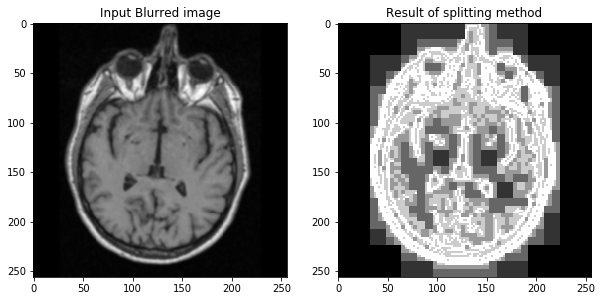

In [252]:
plt.figure(figsize=((10,8)))
plt.subplot(1,2,1)
plt.imshow(brain_blurred,cmap='gray')
plt.title('Input Blurred image')
plt.subplot(1,2,2)
plt.imshow(brain,cmap='gray')
plt.title('Result of splitting method')
plt.show()

The splitting method is defined in this way:
- we consider the all blurred input image and we test the uniform criteria, in this case the criteria test if the std of the image is bigger than a user defined threhsold =15
- if it's not the case we split the image in 4 and we keep going until no splitting is possible

The convergence of the algorithm is reached when the size of the image is equal to 1 or when the uniform criteria is not satified.
Note that when the uniform criteria is not satified, the region is labelled. For each partition of the image we maintain an equal count of label.



In [261]:
brain_split=brain.copy()
brain=np.zeros((np.shape(brain_blurred)[0],np.shape(brain_blurred)[1]))
#splitting method
result2=[]
k=1
threshold=4
index=(0,np.shape(brain_blurred[0])[0],0,np.shape(brain_blurred[1])[0])
if uniform_criteria(index,threshold,brain_blurred):
    
    result=splitting_image_later(index)
    #keep spitting
    while (len(result)!=0):#one matrix defines just by one pixel for just one image-> simple case of square matrix
        for i in range(len(result)):#4 or more output matrix
                if  (uniform_criteria(result[i],threshold,brain_blurred)):
                    result2= result2+list(splitting_image_later(result[i]))#new dimension
                
                else:#label the input image

                    brain[result[i][0]:result[i][1],result[i][2]:result[i][3]]=k
                    k+=1#number of splitting
        
                
        result=result2
        result2=[]

else:
    print('threshold too high')
    

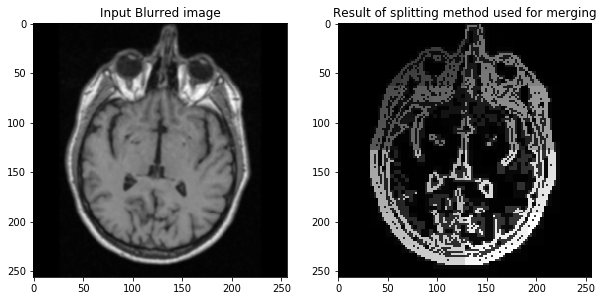

In [262]:
plt.figure(figsize=((10,8)))
plt.subplot(1,2,1)
plt.imshow(brain_blurred,cmap='gray')
plt.title('Input Blurred image')
plt.subplot(1,2,2)
plt.imshow(brain,cmap='gray')
plt.title('Result of splitting method used for merging')
plt.show()

In [270]:
#starting merging algorithm
def get_neighbourhood(i,row,column,brain,merging,brain_blurred,threshold,true_split):
    #4 neighboorhood
    prec_value=0
    if np.shape(row)[0]==1:
        x=1#np.abs(row[0])#1 pixel
        #y=np.abs(column[0])
    else:
        
        x=np.abs(row[0]-row[-1])#matrix
        #y=np.abs(column[0]-column[-1])
        
    
    for j in range(x):
        if (row[0]-1)  >=0:#upper search
            value=brain[row[0]-1,column[0]+j]
            if value!=prec_value:
                merging=merging_f(brain_blurred[brain==i],brain_blurred[brain==value],threshold,merging,i,value,brain,true_split,row,column,row[0]-1,column[0]+j)
                prec_value=value
            
        if (row[-1]+1<=brain.shape[0]-1):#botton search
            value=brain[row[-1]+1,column[0]+j]
            if value!=prec_value:
                merging=merging_f(brain_blurred[brain==i],brain_blurred[brain==value],threshold,merging,i,value,brain,true_split,row,column,row[-1]+1,column[0]+j)
                prec_value=value
            
        if (column[0]-1>=0):#left
            value=brain[row[0]+j,column[0]-1]
            if value!=prec_value:
                merging=merging_f(brain_blurred[brain==i],brain_blurred[brain==value],threshold,merging,i,value,brain,true_split,row,column,row[0]+j,column[0]-1)
                prec_value=value
            
        if (column[-1]+1<=brain.shape[1]-1):#right
            value=brain[row[0]+j,column[-1]+1]
            if value!=prec_value:
                merging=merging_f(brain_blurred[brain==i],brain_blurred[brain==value],threshold,merging,i,value,brain,true_split,row,column,row[0]+j,column[-1]+1)
                prec_value=value
            
    return merging

def merging_f(matrix1,matrix2,threshold,merging,i,value,brain,true_split,row,column,other_row,other_col):
    total_matrix=np.vstack((matrix1.reshape((-1,1)),matrix2.reshape((-1,1))))
    
    if np.std(total_matrix)<=threshold :
        #min_value=min(i,value)
        merging[brain==i]=true_split[row[0],column[0]]
        merging[brain==value]=true_split[row[0],column[0]]
    else:
        merging[brain==i]=true_split[row[0],column[0]]
        merging[brain==value]=true_split[other_row,other_col]
    return merging

In [271]:
#merging
merging=np.zeros((np.shape(brain_blurred)[0],np.shape(brain_blurred)[1]))

for i in range(np.shape(np.unique(brain))[0]-1):
    row,column=np.where(brain==i+1)
    merging=get_neighbourhood(i+1,row,column,brain,merging,brain_blurred,threshold,brain_split)

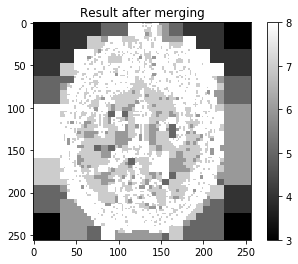

In [272]:
plt.imshow(merging,cmap='gray')
plt.title('Result after merging')
plt.colorbar()
plt.show()

In [273]:
merging2=merging[(merging>5) & (merging<7)]

In [274]:
print('size of the brain region after merge & split:{}'.format(np.count_nonzero(merging2.astype(np.int))))

size of the brain region after merge & split:9184


The merge algorithms works in this way:
- we apply a loop for all the regions found in the split algorithm and we compare if the nearest region can both overcome the threshold (defined in the split algorithm)
- if it is the case we don't merge the region, otherwise we merge them, assigning the minimum labels of the two

We can observe that the split and merge algorithm doen't perform quite good, the brain region is quite hard to find, and we estimated to be included in the range of label:[5-6]

# 1.6 Active contourns

In [275]:
from skimage.filters import gaussian
from skimage.segmentation import active_contour

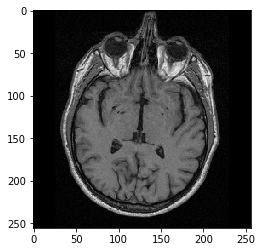

In [276]:
plt.imshow(brain_im,cmap='gray')

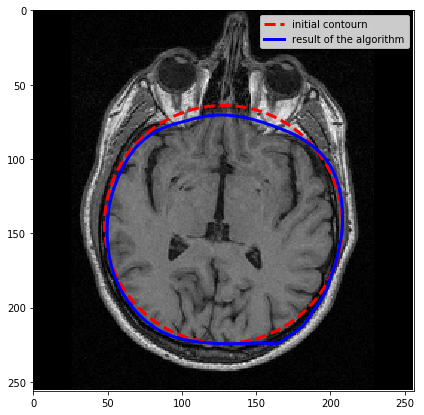

In [287]:
s = np.linspace(0, 2*np.pi, 400)
x = 128+ 80*np.cos(s)
y = 144+80*np.sin(s)
init = np.array([x, y]).T

snake = active_contour(gaussian(brain_im, 3),
                       init, alpha=0.015, beta=10, gamma=0.001)


fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(brain_im, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
#ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, brain_im.shape[1], brain_im.shape[0], 0])
plt.legend(['initial contourn','result of the algorithm'])
plt.show()

In [300]:
values=np.round(np.max(snake,axis=0)-np.min(snake,axis=0))

In [302]:
print('size of the brain region by the active contour is :{}'.format(values[0]*values[1]))

size of the brain region by the active contour is :24332.0


The quality of the result is low, it's really hard to define the initial contour because we have to pay attention to not include the skull or other region of not interest.
The shape of the brain is bigegr respect to the real situation and no solcus or ventriculi can be identified.

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [305]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


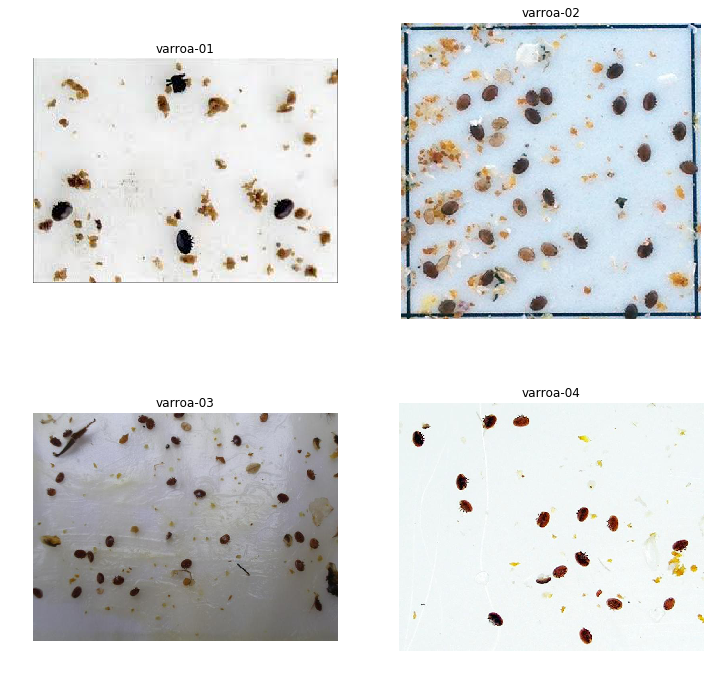

In [306]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [329]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [330]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

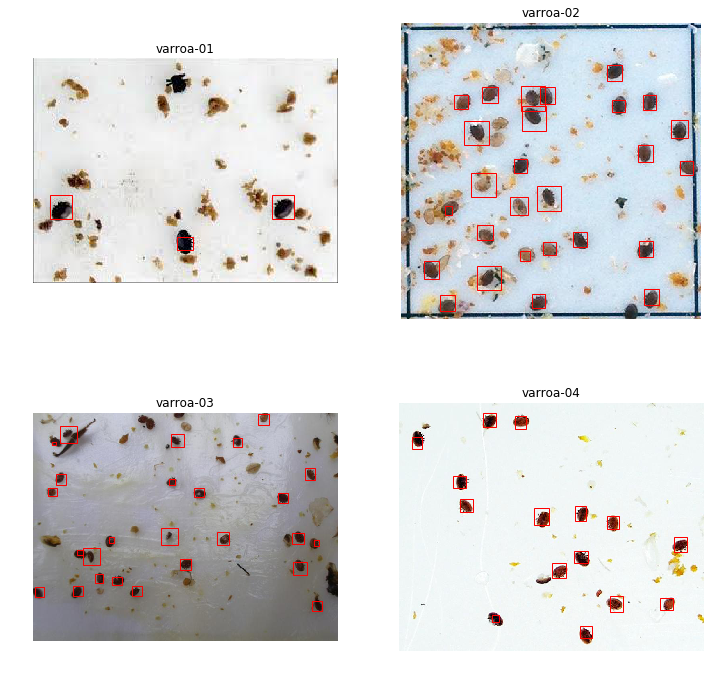

In [331]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

In [307]:
# Convert all imgs to gray
gray_imgs = [skimage.color.rgb2gray(img) * 256 for img in ic]

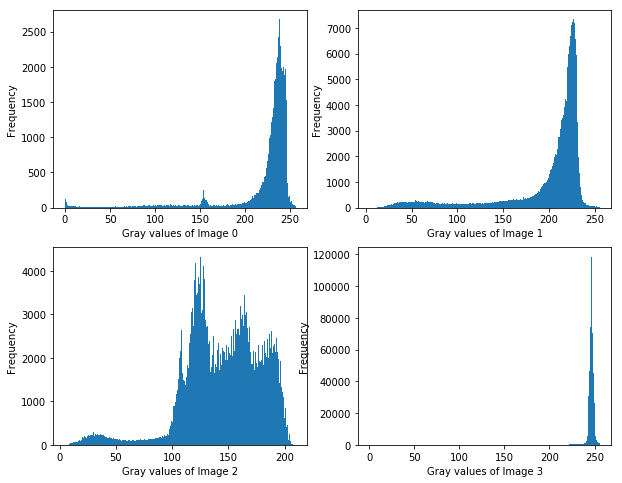

In [308]:
# Explore the histogram of four imgs
fig = plt.figure(figsize = (10, 8))

for i in np.arange(len(gray_imgs)):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.hist(gray_imgs[i].ravel(), bins = 256)
    ax.set_xlabel('Gray values of Image {0}'.format(i))
    ax.set_ylabel('Frequency')

In [309]:
# Set forth img as our example
test_id = 2
test_img = gray_imgs[test_id]

# Set thrshold for filtering 
varroa_thrs = 90

In [310]:
# Build mask for test img
mask = (test_img < varroa_thrs)

# Mask test img
masked_test_img = test_img * mask

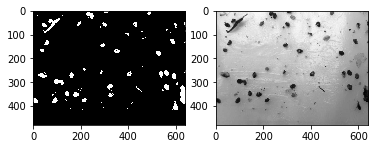

In [311]:
# Compare the mask with test img
plt.subplot(121).imshow(mask, cmap = 'gray')
plt.subplot(122).imshow(test_img, cmap = 'gray')

Notice that there exist some noisy parts in the mask. Furthermore, the sizes of noise tend to be smaller than real obj. This motivates us to filter out noise by setting thrshold on size of obj.
To verify our hypothesis, we illustrate the log distribution of size of obj

In [312]:
# Build label from mask
test_labels = skimage.measure.label(mask)

Text(0.5,1,'Histogram of log size of detected objs')

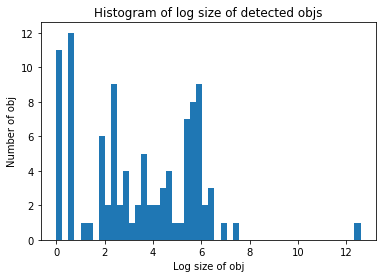

In [313]:
# Check distribution of log size of collections
_ = plt.hist(np.log(np.unique(test_labels, return_counts = True)[1]), bins = 50)
plt.xlabel('Log size of obj')
plt.ylabel('Number of obj')
plt.title('Histogram of log size of detected objs')

Notice that there are many obj with small size, which indicates we are able to filter those noise out by setting an appropriate thrshold on size.
To find a good thrshold, we argue that the histogram of size of obj consists of two distribution, one for noise and the other for real objs.
Then it is natural to set the thrshold to be the mid point of to peaks of two distribution.

In [314]:
# Find size of each labeled obj
index, count = np.unique(test_labels, return_counts = True)

Text(0,0.5,'Count of obj')

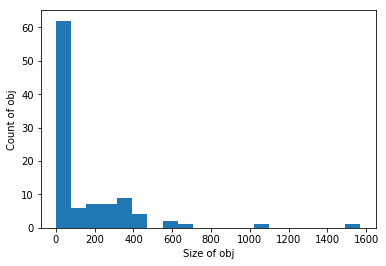

In [315]:
# Illustrate the objs' size distribution
candidate_counts, area_size, _ = plt.hist(count[1 ::], bins = 20)
plt.xlabel('Size of obj')
plt.ylabel('Count of obj')

In [316]:
# Get peaks of two distribution
popular_area_size = area_size[np.argsort(candidate_counts)[:: -1][: 2]]

# Show two peaks' x value
popular_area_size

array([  1. , 314.8])

In [317]:
# Get the thrshold for filtering candidates obj
area_thrshold = np.mean(popular_area_size)

In [318]:
print('The area thrshold for a obj to be valid is {0}'.format(area_thrshold))

The area thrshold for a obj to be valid is 157.9


In [319]:
# Build mask for large obj
index_mask = count > area_thrshold

# Filter out background
index_mask[0] = 0

# Build index mask dict
index_mask_dict = dict(zip(index, index_mask))

Text(0.5,0,'Groundtruth')

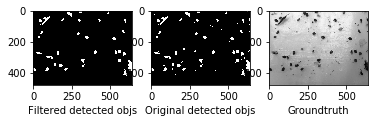

In [320]:
# Illustrate the difference between objs after area filtering and original detected objs
filtered_test_labels = [(x * index_mask_dict.get(x)) > 0 for x in test_labels.ravel()]

filtered_test_labels = np.asarray(filtered_test_labels).reshape(test_img.shape)

# Check filtered result
fig = plt.gcf()
ax = fig.add_subplot(131)
ax.imshow(filtered_test_labels, cmap = 'gray')
ax.set_xlabel('Filtered detected objs')
ax = fig.add_subplot(132)
ax.imshow(test_labels > 0, cmap = 'gray')
ax.set_xlabel('Original detected objs')
ax = fig.add_subplot(133)
ax.imshow(test_img, cmap = 'gray')
ax.set_xlabel('Groundtruth')

In [321]:
# Display the number of obj detected
print('Number of objects detected is {0}'.format(np.sum(index_mask)))

Number of objects detected is 32


### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

In [322]:

def display_obj(img_x, img_y, cors):
    """
    Display objs on img
    Params: img_x : int
            img_y : int
            cors : list
    Return: None
    """
    
    # Initialize img
    img = np.zeros((img_x, img_y))
    
    # Fill img with cors
    img[np.asarray(cors)[::, 0], np.asarray(cors)[::, 1]] = 1
    
    # Display the obj
    plt.imshow(img, cmap = 'gray')

In [323]:
def calculate_IoU(a, b):
    """
    Calculate the IoU of a and b
    Params: a: (a.x, a.y, a.w, a.h)
            b: (b.x, b.y, b.w, b.h)
    Return: IoU(a, b)
    """
    
    # Calculate intersection area
    dx = min(a[0] + a[2], b[0] + b[2]) - max(a[0], b[0])
    dy = min(a[1] + a[3], b[1] + b[3]) - max(a[1], b[1])
    
    # Return zero if no intersection
    if dx <= 0 or dy <= 0:
        return 0
    
    # Set intersection area
    int_area = dx * dy
    
    # Calculate union length
    uni_area = a[2] * a[3] + b[2] * b[3] - int_area
    
    return int_area / uni_area

In [324]:
# Build list of pixel coordinates for each obj
objs = list(map(lambda x: [(i, j) for i in np.arange(test_labels.shape[0])\
                                    for j in np.arange(test_labels.shape[1])\
                                     if test_labels[i][j] == x],
               [k for k in np.arange(len(index_mask)) if index_mask[k] > 0]))

In [326]:
# Build bounding rectangles for objs
# Notice that we need to transpose x and y here
objs_rect = [np.asarray(cv2.boundingRect(np.asarray(obj)))[[1, 0, 3, 2]] for obj in objs]

In [332]:
# Build groundtruth coordinates matrix
gt_objs_rect = [annotations_xmls[test_id][i]['bbox'] for i in np.arange(len(annotations_xmls[test_id]))]

In [333]:
# Find optimal IoU for each candidate obj
opt_iou = [np.max([calculate_IoU(x, y) for y in gt_objs_rect]) for x in objs_rect]

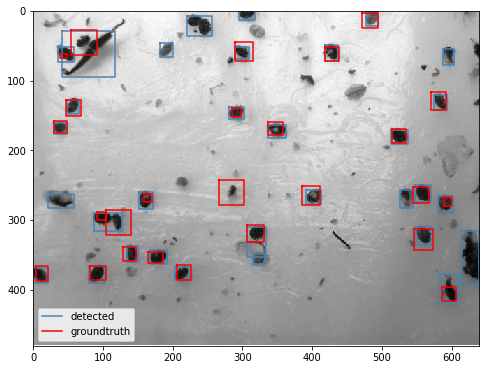

In [334]:
# Visualize the bounding box for ground truth and detected objs
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
ax.set_xlim(0, test_labels.shape[1])
ax.set_ylim(test_labels.shape[0], 0)

for i, p in enumerate(objs_rect):
    
    if i == 0:
        ax.plot((p[0], p[0], p[0] + p[2], p[0] + p[2], p[0]),
                (p[1], p[1] + p[3], p[1] + p[3], p[1], p[1]),
                c = 'steelblue',
               label = 'detected')
    
    else:
        ax.plot((p[0], p[0], p[0] + p[2], p[0] + p[2], p[0]),
                (p[1], p[1] + p[3], p[1] + p[3], p[1], p[1]),
                c = 'steelblue')
        
for i, p in enumerate(gt_objs_rect):
    
    if i == 0:
        
        ax.plot((p[0], p[0], p[0] + p[2], p[0] + p[2], p[0]),
                (p[1], p[1] + p[3], p[1] + p[3], p[1], p[1]),
                c = 'red',
               label = 'groundtruth') 
        
    else: 
 
        ax.plot((p[0], p[0], p[0] + p[2], p[0] + p[2], p[0]),
                (p[1], p[1] + p[3], p[1] + p[3], p[1], p[1]),
                c = 'red') 
    
ax.legend()
ax.imshow(test_img, cmap = 'gray')

Text(0.5,1,'Histogram of IoU values')

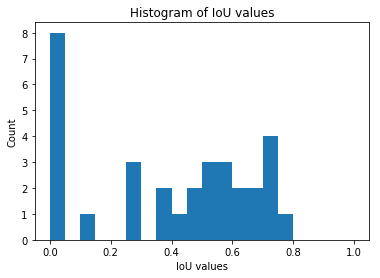

In [335]:
# Display optimal IoU
plt.hist(opt_iou, range = [0, 1], bins = 20)
plt.xlabel('IoU values')
plt.ylabel('Count')
plt.title('Histogram of IoU values')

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion

In [336]:
# Set IoU thrs to 0.5
iou_thrs = [0.5, 0.9]

In [337]:

# Set metrics to be evaluated
types = ['Accuracy', 'Recall', 'F1-score']

In [338]:
def cal_stats(values, thrs, gt):
    """
    Calculate precision, recall and f1_score for given thrshold
    Param: values : np.array
           thrs : double
           gt : ground truth
    Return: (prec, recall, f1_score)
    """
    
    # Get boolean judgment for values using thrs
    results = np.asarray(values) > thrs
    
    # Get prec
    prec = np.sum(results) / len(values)
    
    # Get rec
    rec = np.sum(results) / len(gt)
    
    # Get f1_score
    f1 = 2 * prec * rec / (prec + rec)
    
    return (prec, rec, f1)

In [339]:
# Calculate statistics for all thrsholds
iou_thrs_stats = dict(zip(iou_thrs, [cal_stats(opt_iou, thrs, gt_objs_rect) for thrs in iou_thrs]))

/Users/elisabetta/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [341]:
# Display the results
import pandas as pd
# Build iou_thrs_stats as pandas dataframe
iou_thrs_stats_df = pd.DataFrame(iou_thrs_stats, index = ['prec', 'rec', 'f1_score'])

iou_thrs_stats_df

,0.5,0.9
prec,0.468750,0.0
rec,0.576923,0.0
f1_score,0.517241,NaN


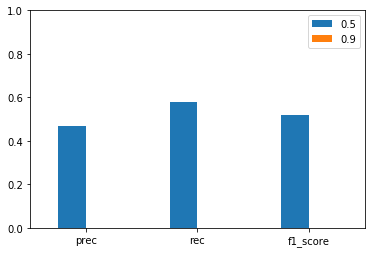

In [342]:

iou_thrs_stats_df.plot(kind = 'bar', rot = 0, ylim = (0, 1))

So far we have elaborated the whole procedure for varroa detection and result evaluation using one img.
We then build functions to enable same process for every img.
For simplicity we omit figure illustration in the general function

In [346]:
def detect(img, thrs):
    """
    Detect bounding rectangles of objects in the grayscale img using given thrs
    Param:  img: np.array
            thrs: double
    Return: list of bounding rect
    """
    
    # Build binary img using thrshold
    masked_img = img < thrs
    
    # Find labels for masked img
    labels = skimage.measure.label(masked_img)
    
    # Compute two obj area thrshold 
    index, count = np.unique(labels, return_counts = True)
    
    candidate_counts, area_size, _ = plt.hist(count[1 ::], bins = 20)
    
    area_thrs = np.mean(area_size[np.argsort(candidate_counts)[:: -1][: 2]])

    # Filter out small objs
    index_mask = count > area_thrs
    
    index_mask[0] = 0

    index_mask_dict = dict(zip(index, index_mask))

    filtered_labels = np.asarray([index_mask_dict.get(x) > 0
                                for x in labels.ravel()]).reshape(img.shape)

    # Build bounding rectangle for each obj
    objs = list(map(lambda x: [(i, j) for i in np.arange(labels.shape[0])\
                                    for j in np.arange(labels.shape[1])\
                                     if labels[i][j] == x],
               [k for k in np.arange(len(index_mask)) if index_mask[k] > 0]))
    
    objs_rect = [np.asarray(cv2.boundingRect(np.asarray(obj)))[[1, 0, 3, 2]] for obj in objs]
    
    return objs_rect

In [344]:
results_df = pd.DataFrame(index = np.arange(len(gray_imgs)),
                          columns = [columns[0], columns[1]])

/Users/elisabetta/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in double_scalars


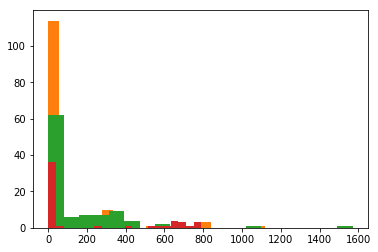

In [347]:
# Display evaluation results for all imgs

# Initialize results dataframe
a, b = np.meshgrid(types, iou_thrs)
columns = np.column_stack((np.column_stack(a).ravel(), np.column_stack(b).ravel())).T

results_df = pd.DataFrame(index = np.arange(len(gray_imgs)),
                          columns = [columns[0], columns[1]])
results_df.index.name = 'Img'

# Loop through all img
for i in np.arange(len(gray_imgs)):
    
    # Get the objs rect
    objs_rect = detect(gray_imgs[i], varroa_thrs)
    
    # Get the ground truth rect
    gt_objs_rect = [annotations_xmls[i][j]['bbox'] for j in np.arange(len(annotations_xmls[i]))]
    
    # Compute evaluation results for all iou_thrs
    stats = [cal_stats([np.max([calculate_IoU(a, b) for b in gt_objs_rect])
                        for a in objs_rect], iou_thrs_instance, gt_objs_rect)
                for iou_thrs_instance in iou_thrs]
    
    results_df.loc[i] = np.column_stack(stats).ravel()

In [348]:
# Illustrate the result
results_df

Accuracy        Recall      F1-score     
          0.5 0.9       0.5 0.9       0.5  0.9
Img                                           
0    0.107143   0         1   0  0.193548  NaN
1    0.294118   0   0.37037   0  0.327869  NaN
2     0.46875   0  0.576923   0  0.517241  NaN
3         0.8   0       0.8   0       0.8  NaN